In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries

from darts.models import LightGBMModel, XGBoost Prophet

from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.dataprocessing import Pipeline

from darts.metrics import mape

import mlflow

c:\Users\jeany\anaconda3\envs\Projektseminar39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
absences_df = pd.read_csv('../../data/processed/absences_daily.csv')
absences_df

,date,count
0,2020-01-02,2
1,2020-01-03,2
2,2020-01-04,2
3,2020-01-15,4
4,2020-01-16,4
...,...,...
1452,2024-01-03,51
1453,2024-01-04,45
1454,2024-01-05,32
1455,2024-01-06,21


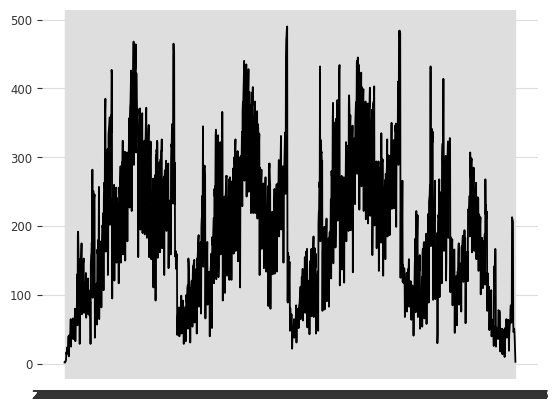

In [3]:
plt.plot(absences_df['date'], absences_df['count'])

In [4]:
series = TimeSeries.from_dataframe(absences_df, time_col='date', value_cols='count', fill_missing_dates=True, freq='D')

In [5]:
single_train_ts, single_test_ts = series.split_before(pd.Timestamp('2023-01-01'))


In [6]:
pipeline = Scaler()
#pipeline = Pipeline([Scaler(), StaticCovariatesTransformer()]) # MinMaxScaler
train_dataset_ts_prepared = pipeline.fit_transform(single_train_ts)
test_dataset_ts_prepared = pipeline.transform(single_test_ts)

In [7]:
forecast_horizons = len(single_test_ts)

In [24]:
model_lightGBM = LightGBMModel(lags=2, 
                            output_chunk_length=356, 
                            random_state=0,
                            multi_models=False, 
                            #lags_past_covariates=past_lags,
                            #lags_future_covariates=future_lags,
                            add_encoders={"cyclic": {"future": ["month"]}, 
                                         'datetime_attribute': {'future': ['dayofweek']},
                                         'position': {'past': ['relative'], 'future': ['relative']},}
                                         #'transformer': Scaler()}
                            )

model_lightGBM.fit(series=train_dataset_ts_prepared)
prediction_lightGBM = model_lightGBM.predict(n=forecast_horizons, series=train_dataset_ts_prepared)
prediction_lightGBM = pipeline.inverse_transform(prediction_lightGBM)

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 738, number of used features: 2
[LightGBM] [Info] Start training from score 0.470220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

137.7953526210893


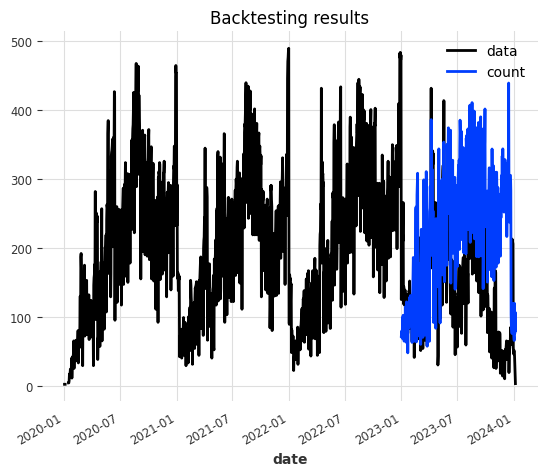

In [9]:
series.plot(label='data')

err = mape(actual_series=single_test_ts, pred_series=prediction_lightGBM)
prediction_lightGBM.plot()

plt.title('Backtesting results')
plt.legend()

print(err)

In [10]:
from mlflow import MlflowClient 
from mlflow.models import infer_signature

In [12]:
mlflow.set_tracking_uri('./mlruns')
mlflow.set_experiment('LightGBMModel')
experiment = mlflow.get_experiment_by_name('LightGBMModel')
client = MlflowClient()

run = client.create_run(experiment.experiment_id)

with mlflow.start_run(run_id=run.info.run_id) as run:

    model_lightGBM.fit(series=train_dataset_ts_prepared)
    #signature = infer_signature(test_dataset_ts_prepared, model_lightGBM.predict(n=forecast_horizons, series=train_dataset_ts_prepared))
    
    mlflow.lightgbm.log_model(model_lightGBM, 'model')

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 738, number of used features: 2
[LightGBM] [Info] Start training from score 0.470220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [13]:
loaded_model = mlflow.lightgbm.load_model('./mlruns/985497283900259339/1bb7d01fa8fc4bf8b8c83d9634ff93c7/artifacts/model')

In [18]:
prediction_lightGBM = loaded_model.predict(n=forecast_horizons, series=train_dataset_ts_prepared)
prediction_lightGBM = pipeline.inverse_transform(prediction_lightGBM)

137.7953526210893


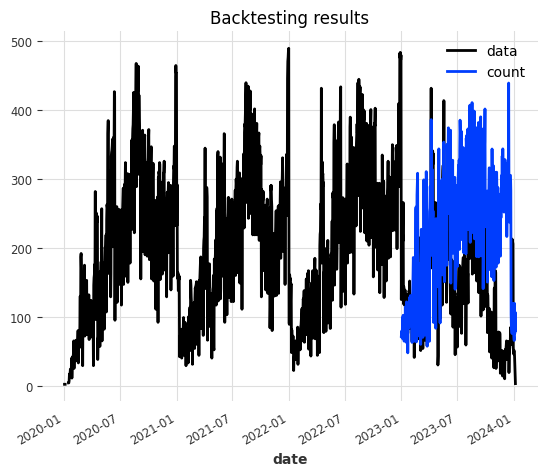

In [19]:
series.plot(label='data')

err = mape(actual_series=single_test_ts, pred_series=prediction_lightGBM)
prediction_lightGBM.plot()

plt.title('Backtesting results')
plt.legend()

print(err)